<a href="https://colab.research.google.com/github/Abhishekn1947/Ghibli-Diffuser-Open-Source/blob/main/ghibly_diffuser_v0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision diffusers peft python-dotenv pillow

In [ ]:
import torch
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, DPMSolverMultistepScheduler
from peft import LoraConfig, get_peft_model
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from IPython.display import display
import google.colab.files
import shutil
from torch.cuda.amp import autocast, GradScaler

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
print(f"GPU Name: {torch.cuda.get_device_name(0)}")
print(f"VRAM Available: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB / {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

Using device: cuda
GPU Name: NVIDIA A100-SXM4-40GB
VRAM Available: 0.00 GB / 39.56 GB


In [ ]:
MODEL_ID = "runwayml/stable-diffusion-v1-5"
LORA_WEIGHTS_PATH = "ghibli_lora_weights.pt"
INPUT_DIR = "input"
OUTPUT_DIR = "output"
DATASET_DIR = "ghibli_dataset"
REGULARIZATION_DIR = "regularization_dataset"

os.makedirs(DATASET_DIR, exist_ok=True)
os.makedirs(REGULARIZATION_DIR, exist_ok=True)
os.makedirs(INPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
print("Directories created:", DATASET_DIR, REGULARIZATION_DIR, INPUT_DIR, OUTPUT_DIR)

Directories created: ghibli_dataset regularization_dataset input output


In [ ]:
print("Upload your 'ghibli_dataset' folder containing 1000 Ghibli images (select all images inside the folder):")
uploaded = google.colab.files.upload()
if uploaded:
    for filename, content in uploaded.items():
        if filename.endswith((".jpg", ".png")):
            target_path = os.path.join(DATASET_DIR, filename)
            with open(target_path, "wb") as f:
                f.write(content)
    image_files = [f for f in os.listdir(DATASET_DIR) if f.endswith((".jpg", ".png"))]
    print(f"Uploaded {len(image_files)} image files to {DATASET_DIR}: {image_files[:5]} (showing first 5)")
    if len(image_files) == 0:
        raise Exception("No valid image files uploaded to ghibli_dataset! Ensure you selected .jpg or .png files.")
else:
    raise Exception("No files uploaded! Please upload your ghibli_dataset folder contents.")

Upload your 'ghibli_dataset' folder containing 1000 Ghibli images (select all images inside the folder):


Saving 0.jpg to 0.jpg
Saving 0a1fd060-1dff-41a3-b3ee-91d3e02da756.gif to 0a1fd060-1dff-41a3-b3ee-91d3e02da756.gif
Saving 0a67cad3-53a1-4de0-948a-b2b38343d1b9.png to 0a67cad3-53a1-4de0-948a-b2b38343d1b9.png
Saving 0abb920d-580d-49fb-80ce-55aea03b47c8.jpg to 0abb920d-580d-49fb-80ce-55aea03b47c8.jpg
Saving 0ad24b10-82f8-453c-a1cf-c5f3a52b76ab.jpg to 0ad24b10-82f8-453c-a1cf-c5f3a52b76ab.jpg
Saving 0b6fb268-6b37-45ed-b62b-b1bb9ab07ecd.jpg to 0b6fb268-6b37-45ed-b62b-b1bb9ab07ecd.jpg
Saving 000bcde3-44ed-4d4e-bef9-69f6f5872d44.jpg to 000bcde3-44ed-4d4e-bef9-69f6f5872d44.jpg
Saving 0bcf7d3c-23b6-4d44-ad1c-28bb34986096.jpg to 0bcf7d3c-23b6-4d44-ad1c-28bb34986096.jpg
Saving 0bf3180a-6835-4fc0-a88a-ea642e4b1193.gif to 0bf3180a-6835-4fc0-a88a-ea642e4b1193.gif
Saving 0c0f1014-4284-4a96-80c3-abb46b0658b5.jpg to 0c0f1014-4284-4a96-80c3-abb46b0658b5.jpg
Saving 0c4d0a39-2e1d-43ec-ac64-7fd131572d7f.jpg to 0c4d0a39-2e1d-43ec-ac64-7fd131572d7f.jpg
Saving 0c77bc50-1853-4332-b5a3-44764ddf2d75.jpg to 0c77bc5

In [ ]:
print("Upload your 'regularization_dataset' folder containing up to 250 generic photos (select images inside the folder):")
uploaded = google.colab.files.upload()
if uploaded:
    reg_count = 0
    for filename, content in uploaded.items():
        if filename.endswith((".jpg", ".png")) and reg_count < 250:
            target_path = os.path.join(REGULARIZATION_DIR, filename)
            with open(target_path, "wb") as f:
                f.write(content)
            reg_count += 1
    reg_files = [f for f in os.listdir(REGULARIZATION_DIR) if f.endswith((".jpg", ".png"))]
    print(f"Uploaded {len(reg_files)} image files to {REGULARIZATION_DIR}: {reg_files[:5]} (showing first 5)")
    if len(reg_files) == 0:
        raise Exception("No valid image files uploaded to regularization_dataset! Ensure you selected .jpg or .png files.")
else:
    print("No regularization files uploaded. Proceeding without regularization.")

Upload your 'regularization_dataset' folder containing up to 250 generic photos (select images inside the folder):


Saving 0a1a0ab62fa27cf0.jpg to 0a1a0ab62fa27cf0.jpg
Saving 0a1d868ba728ae2f.jpg to 0a1d868ba728ae2f.jpg
Saving 0a1f58c7e384c744.jpg to 0a1f58c7e384c744.jpg
Saving 0a02dfd001206b07.jpg to 0a02dfd001206b07.jpg
Saving 0a2ed15a86b0025f.jpg to 0a2ed15a86b0025f.jpg
Saving 0a3ca9af21ca6709.jpg to 0a3ca9af21ca6709.jpg
Saving 0a4a663bdd196c71.jpg to 0a4a663bdd196c71.jpg
Saving 0a4e511e0675bf3d.jpg to 0a4e511e0675bf3d.jpg
Saving 0a5f6d5cd19eb349.jpg to 0a5f6d5cd19eb349.jpg
Saving 00a06e610f2d6fc2.jpg to 00a06e610f2d6fc2.jpg
Saving 0a6f15feca2d7ab7.jpg to 0a6f15feca2d7ab7.jpg
Saving 0a07b5572d3e4602.jpg to 0a07b5572d3e4602.jpg
Saving 0a7eb71b084a5875.jpg to 0a7eb71b084a5875.jpg
Saving 0a8fecf927a70f33.jpg to 0a8fecf927a70f33.jpg
Saving 0a9c0c02c8b68b7b.jpg to 0a9c0c02c8b68b7b.jpg
Saving 0a18a0eecdc07440.jpg to 0a18a0eecdc07440.jpg
Saving 0a33b9cf815ee0bd.jpg to 0a33b9cf815ee0bd.jpg
Saving 0a37ab7756aae1a2.jpg to 0a37ab7756aae1a2.jpg
Saving 000a42c09609c847.jpg to 000a42c09609c847.jpg
Saving 0a44d

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataset_dir, is_instance=True):
        self.image_paths = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith((".jpg", ".png"))]
        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ])
        self.is_instance = is_instance

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        return self.transform(img), "Studio Ghibli style" if self.is_instance else "a photo"

In [ ]:
def fine_tune_model():
    print("Loading Stable Diffusion model...")
    pipe = StableDiffusionPipeline.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float16,
        use_safetensors=True
    )
    pipe = pipe.to(device)

    lora_config = LoraConfig(
        r=48,  # Increased capacity
        lora_alpha=96,  # Stronger adaptation
        target_modules=["to_q", "to_k", "to_v"],
        lora_dropout=0.1
    )
    pipe.unet = get_peft_model(pipe.unet, lora_config)

    instance_dataset = CustomDataset(DATASET_DIR, is_instance=True)
    reg_dataset = CustomDataset(REGULARIZATION_DIR, is_instance=False)
    if len(instance_dataset) == 0:
        raise Exception("No images found in ghibli_dataset!")
    if len(reg_dataset) == 0:
        print("Warning: No regularization images. Training without regularization.")
    instance_loader = DataLoader(instance_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)  # Reduced for gradient accumulation
    reg_loader = DataLoader(reg_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True) if reg_dataset else None
    reg_iterator = iter(reg_loader) if reg_loader else None

    optimizer = torch.optim.AdamW(pipe.unet.parameters(), lr=5e-5)  # Higher initial LR
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)  # Slower decay
    scaler = torch.amp.GradScaler('cuda')
    pipe.unet.train()
    num_epochs = 15
    best_loss = float('inf')
    patience = 7  # More patience
    no_improve = 0
    instance_weight = 2.0  # Stronger Ghibli emphasis
    accum_steps = 2  # Gradient accumulation for effective batch size of 8

    print(f"Starting fine-tuning with {len(instance_dataset)} instance images and {len(reg_dataset)} regularization images...")
    for epoch in range(num_epochs):
        total_loss = 0.0
        total_reg_loss = 0.0
        num_batches = 0
        optimizer.zero_grad()

        for i, instance_batch in enumerate(instance_loader):
            imgs, prompt = instance_batch
            batch_size = imgs.shape[0]
            imgs = imgs.to(device, dtype=torch.float16)

            with torch.no_grad():
                latents = pipe.vae.encode(imgs).latent_dist.sample() * pipe.vae.config.scaling_factor

            text_inputs = pipe.tokenizer([prompt[0]] * batch_size, return_tensors="pt", padding=True)
            text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
            encoder_hidden_states = pipe.text_encoder(**text_inputs)[0]

            noise = torch.randn_like(latents)
            timesteps = torch.randint(0, pipe.scheduler.config.num_train_timesteps, (batch_size,), device=device).long()
            noisy_latents = pipe.scheduler.add_noise(latents, noise, timesteps)

            with torch.amp.autocast('cuda'):
                noise_pred = pipe.unet(noisy_latents, timesteps, encoder_hidden_states).sample
                loss = instance_weight * torch.nn.functional.mse_loss(noise_pred, noise)
            scaler.scale(loss).backward()

            if (i + 1) % accum_steps == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(pipe.unet.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            total_loss += loss.item() / instance_weight
            num_batches += 1

            if reg_iterator:
                try:
                    reg_batch = next(reg_iterator)
                except StopIteration:
                    reg_iterator = iter(reg_loader)
                    reg_batch = next(reg_iterator)
                reg_imgs, reg_prompt = reg_batch
                reg_batch_size = reg_imgs.shape[0]
                reg_imgs = reg_imgs.to(device, dtype=torch.float16)
                with torch.no_grad():
                    reg_latents = pipe.vae.encode(reg_imgs).latent_dist.sample() * pipe.vae.config.scaling_factor
                reg_text_inputs = pipe.tokenizer([reg_prompt[0]] * reg_batch_size, return_tensors="pt", padding=True)
                reg_text_inputs = {k: v.to(device) for k, v in reg_text_inputs.items()}
                reg_encoder_hidden_states = pipe.text_encoder(**reg_text_inputs)[0]
                reg_noise = torch.randn_like(reg_latents)
                reg_timesteps = torch.randint(0, pipe.scheduler.config.num_train_timesteps, (reg_batch_size,), device=device).long()
                reg_noisy_latents = pipe.scheduler.add_noise(reg_latents, reg_noise, reg_timesteps)
                with torch.amp.autocast('cuda'):
                    reg_noise_pred = pipe.unet(reg_noisy_latents, reg_timesteps, reg_encoder_hidden_states).sample
                    reg_loss = torch.nn.functional.mse_loss(reg_noise_pred, reg_noise)
                scaler.scale(reg_loss).backward()

                if (i + 1) % accum_steps == 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(pipe.unet.parameters(), max_norm=1.0)
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()

                total_reg_loss += reg_loss.item()

        scheduler.step()
        avg_loss = total_loss / num_batches
        avg_reg_loss = total_reg_loss / num_batches if reg_iterator else 0.0
        print(f"Epoch {epoch + 1}/{num_epochs} completed. Avg Instance Loss: {avg_loss:.4f}, Avg Reg Loss: {avg_reg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                break

    torch.save(pipe.unet.state_dict(), LORA_WEIGHTS_PATH)
    print(f"Fine-tuned weights saved to {LORA_WEIGHTS_PATH}")

In [ ]:
fine_tune_model()

Loading Stable Diffusion model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Starting fine-tuning with 1022 instance images and 250 regularization images...
Epoch 1/15 completed. Avg Instance Loss: 0.1492, Avg Reg Loss: 0.1493, LR: 0.000050
Epoch 2/15 completed. Avg Instance Loss: 0.1469, Avg Reg Loss: 0.1464, LR: 0.000050
Epoch 3/15 completed. Avg Instance Loss: 0.1492, Avg Reg Loss: 0.1545, LR: 0.000050
Epoch 4/15 completed. Avg Instance Loss: 0.1494, Avg Reg Loss: 0.1502, LR: 0.000050
Epoch 5/15 completed. Avg Instance Loss: 0.1381, Avg Reg Loss: 0.1634, LR: 0.000050
Epoch 6/15 completed. Avg Instance Loss: 0.1489, Avg Reg Loss: 0.1479, LR: 0.000050
Epoch 7/15 completed. Avg Instance Loss: 0.1385, Avg Reg Loss: 0.1494, LR: 0.000025
Epoch 8/15 completed. Avg Instance Loss: 0.1442, Avg Reg Loss: 0.1509, LR: 0.000025
Epoch 9/15 completed. Avg Instance Loss: 0.1389, Avg Reg Loss: 0.1601, LR: 0.000025
Epoch 10/15 completed. Avg Instance Loss: 0.1429, Avg Reg Loss: 0.1555, LR: 0.000025
Epoch 11/15 completed. Avg Instance Loss: 0.1411, Avg Reg Loss: 0.1549, LR: 0.0

In [19]:
def apply_ghibli_filter(input_path, strength=0.2, prompt="Studio Ghibli style artwork, vibrant pastel colors, whimsical characters, lush detailed backgrounds, hand-painted aesthetic"):
    print("Loading inference pipeline...")
    pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float16,
        use_safetensors=True
    )
    pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
    pipe = pipe.to(device)

    lora_config = LoraConfig(
        r=48,
        lora_alpha=96,
        target_modules=["to_q", "to_k", "to_v"],
        lora_dropout=0.1
    )
    pipe.unet = get_peft_model(pipe.unet, lora_config)
    pipe.unet.load_state_dict(torch.load(LORA_WEIGHTS_PATH, map_location=device), strict=False)

    init_image = Image.open(input_path).resize((512, 512))
    with torch.amp.autocast('cuda'):
        result = pipe(
            prompt=prompt,
            image=init_image,
            strength=strength,
            guidance_scale=8.5,
            num_inference_steps=50
        ).images[0]
    return result

Upload an image to transform:


Saving 11113.jpg to 11113 (1).jpg
Loading inference pipeline...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

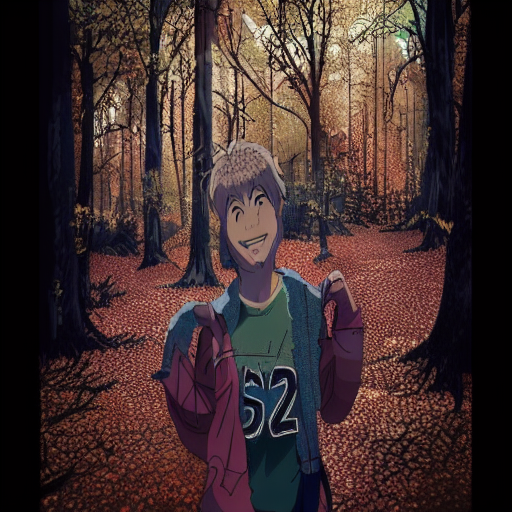

Generated image saved to output/ghibli_11113 (1).jpg


In [21]:
print("Upload an image to transform:")
uploaded = google.colab.files.upload()
if uploaded:
    input_filename = list(uploaded.keys())[0]
    input_path = os.path.join(INPUT_DIR, input_filename)
    with open(input_path, "wb") as f:
        f.write(uploaded[input_filename])

    output_path = os.path.join(OUTPUT_DIR, f"ghibli_{input_filename}")
    result = apply_ghibli_filter(input_path)
    result.save(output_path)
    display(result)
    print(f"Generated image saved to {output_path}")
else:
    print("No image uploaded!")

In [14]:
google.colab.files.download(LORA_WEIGHTS_PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>